# Umbrella Sampling of the two-well potential

Here, we define an umbrella sampling object, `UmbrellaSampler()` that can perform biased sampling of the two-well potential.

In [7]:
import os, sys
import numpy as np

class UmbrellaSampler(object):
    """A Sampler class that can perform biased sampling of the two-well potential."""
    
    def __init__(self,
                 x0_values = [0.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5],
                 kspring_values  = ([0.0]+[2.0]*9) ):
        """Initialize the UmbrellaSampler class.
        
        PARAMETERS
        x0_values - a list of x0 positions of the umbrella anchors
        kspring_values  - a list of force constant values, in kcal/mol/[x]^2
        """
        
        self.x0_values = x0_values  # Umbrella anchor positions
        self.kspring_values = kspring_values    # force constant values, in kcal/mol/[x]^2
        
        assert len(self.x0_values) == len(self.kspring_values)
        
        self.K = len(self.x0_values)  # the number of thermodynamic ensembles
        
    
    def U(self, x, x0=0.0, kspring=0.0):
        """Return the value of the **biased** 1D potential energy surface in kcal/mol:

        U(x) = -2 \ln [ e^{-2(x-2)^2-2} + e^{-2(x-5)^2} ] + (k/2.)(x - x0)**2
        """
        result = -2.0*np.log( np.exp(-2.0*(x-2)**2 - 2) + np.exp(-2.0*(x-5)**2) )
        result += kspring/2.*(x - x0)**2
        return result

    
    def dU_kl(self, x, k, l):
        """Return the difference of the potential energy $\Delta U_kl(x)$ for a snapshot
        from ensemble index k, re-evaluated in ensemble index l:
        
        \Delta U_kl(x) = (bias from ens. l) - (bias from ens k.)
        
        """
        result = self.kspring_values[l]/2.*(x - self.x0_values[l])**2
        result -= self.kspring_values[k]/2.*(x - self.x0_values[k])**2
         
        return result


    def sample(self, xinit, nsteps, thermo_index, djump=0.05, xmin=1.5, xmax=5.5,
               kT=0.596, nstride=100, nprint=10000, verbose=False):
        """Perform Monte Carlo sampling of the potential energy surface U
        by 

        INPUT
        xinit        - the starting position
        nsteps       - number of steps of Monte Carlo to perform
        thermo_index - the index of the thermodynamic ensemble to sample
        
        PARAMS
        djump    attempt random moves drawn from [-djump, +djump]
        xmin     reject moves x < xmin
        xmax     reject moves x > xmax
        kT       thermal energy in units of kcal/mol (Default: 0.596)
        nstride  frequency of step to subsample the trajectory

        Note:  the djump=0.005 parameter is from the 2017 Stelzl et al. paper    
        """
        
        assert (thermo_index < self.K)
        
        x = xinit
        energy = self.U(x, self.x0_values[thermo_index], self.kspring_values[thermo_index])

        step = 0
        accepted_steps = 0
        traj = np.zeros( int(nsteps/nstride) )
        itraj = 0

        # pre-calculate random numbers
        r = np.random.random( nsteps )
        s = np.random.random( nsteps )

        while step < nsteps:

            xnew = x + djump*(2.0*s[step]-1.0)
            new_energy = self.U(xnew, self.x0_values[thermo_index], self.kspring_values[thermo_index])

            # calculate Metropolis acceptance 
            accept = (r[step] < min(1, np.exp( -1.0*(new_energy-energy)/kT ) ))

            # reject moves that bring x outside the range
            accept = accept*(xnew>xmin)*(xnew<xmax)

            if accept:
                accepted_steps += 1
                x = xnew
                energy = self.U(x, self.x0_values[thermo_index], self.kspring_values[thermo_index])

            if step%nstride == 0:
                traj[itraj] = x
                itraj += 1

            if verbose:
                if step%nprint == 0:
                    print('step', step, 'of', nsteps, ': x =', x, 'energy =', energy)

            step += 1
            acc_ratio = float(accepted_steps)/float(step)

        return traj



Here's a plot of what all the biased potentials in each ensemble looks like:

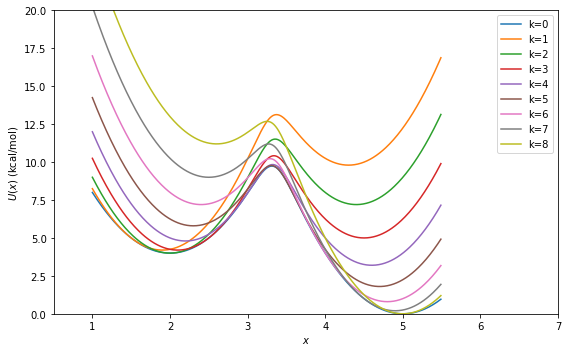

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

s = UmbrellaSampler()
K = 9

plt.figure(figsize=(8,5))
x = np.arange(1.0, 5.5, 0.01)
for k in range(K):
    plt.plot(x, s.U(x, s.x0_values[k], s.kspring_values[k]), label='k=%d'%k)
plt.xlabel('$x$')
plt.ylabel('$U(x)$ (kcal/mol)')
plt.legend(loc='upper right')
plt.xlim(0.5, 7.0)
plt.ylim(0,20)
plt.tight_layout()

In [9]:
import os, sys
#  Let's define some functions to write and read the trajectory data

def save_trajdata(s, trajdata, trajname, outdir='./trajdata'):
    """Output trajectory data files to the specified outdir.
    
    INPUT
    s                      - an UmbrellaSampler object
    
    trajdata               - a numpy array of shape (K, ntrials, nsamples)
    
    
    will write:
    
    [trajname].npy         - the numpy array written to binary
    [trajname].description - a text file with the information about each ensemble
    
    """
    
    K, ntrials, nsamples = trajdata.shape
    
    # write the numpy data
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        
    outfile = os.path.join(outdir, trajname+'.npy')
    print('Writing', outfile, '...')
    np.save(outfile, trajdata)
    print('...Done.')
    
    # write the description
    descfile = os.path.join(outdir, trajname+'.description')
    print('Writing', descfile, '...')
    fout = open(descfile, 'w')
    fout.write('# thermo_index\tx0_umbrella_center\tkspring(kcal/mol/[x]^2)\n')
    fout.write('# ntrials %d\n'%ntrials)
    fout.write('# nsamples %d\n'%nsamples)
    for k in range(K):
        fout.write('%d\t%1.3f\t%1.3f\n'%(k, s.x0_values[k], s.kspring_values[k])) 
    fout.close()
    print('...Done.')
    

### Let's perform some sampling under different conditions.

We'll keep the same:
* number of umbrellas and their anchor points,
* and the same number of trials (10)

and we'll vary:
* the **strength** of the harmonic biases,
* and **number of samples**


In [26]:
for kspring in [1.0, 2.0, 5.0, 10.0]:
    for n in [200000, 500000, 1000000]:
        
        s = UmbrellaSampler(
                x0_values = ([0.0] + [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]),
                kspring_values  = ([0.0] + [kspring]*7) )

        ntrials = 10
        xinit_per_trial = [2.0, 5.0]*5   #  start every other trajectory from left well, then right well


        nsteps = n
        nstride = 100
        nsamples = int(nsteps/nstride)

        project_title = 'nsamples%d_kspring%3.1f'%(nsamples, kspring)

        # create an empty array to store the data
        trajdata = np.zeros( (s.K, ntrials, nsamples))
        print('trajdata.shape', trajdata.shape)
        print('The `trajdata` array uses', trajdata.nbytes, 'bytes')

        # perform sampling
        for k in range(s.K):
            print('traj', k, 'of', s.K, '| trial (of %d): '%ntrials, end ='')
            for trial in range(ntrials):
                trajdata[k,trial,:] = s.sample(xinit_per_trial[trial],
                                               nsteps, k, nstride=nstride,
                                               xmin=-100.0, xmax=100.0)   # make
                print(trial, end = ' ')
            print('')

        # save the trajectory data
        save_trajdata(s, trajdata, project_title)
        
        del trajdata
        del s
        

trajdata.shape (8, 10, 2000)
The `trajdata` array uses 1280000 bytes
traj 0 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 1 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 2 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 3 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 4 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 5 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 6 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 7 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
Writing ./trajdata/nsamples2000_kspring1.0.npy ...
...Done.
Writing ./trajdata/nsamples2000_kspring1.0.description ...
...Done.
trajdata.shape (8, 10, 5000)
The `trajdata` array uses 3200000 bytes
traj 0 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 1 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 2 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 3 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 4 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 5 of 8 | trial (of 10): 0 1 2 3 4 5 6 7 8 9 
traj 6 of 8 | trial (of 10): 0 1 2

In [25]:
# Plot the results    
plt.figure(figsize=(8,10))
for k in range(s.K):
    plt.subplot(s.K,1,k+1)
    for trial in range(ntrials):
        plt.plot(trajdata[k,trial,:], range(nsamples))
    if k == (s.K-1):
        plt.xlabel('$x$')
    plt.ylabel('K = %d'%k)
    plt.xlim(0,7.0)
plt.tight_layout()

NameError: name 's' is not defined

<Figure size 576x720 with 0 Axes>

## MBAR estimation of the free energy between wells

In [23]:
from pymbar import MBAR # multistate Bennett acceptance ratio
from pymbar import timeseries # timeseries analysis

VERBOSE = False

# To estimate errors from finite sampling, we'll compute free energies using data from
# trials 0 and 1, then 2 and 3, etc., because every two trial starts from the left and right basin
nbootstraps = int(ntrials/2)
F_estimates, dF_estimates = [], []  # estimates over bootstraps

for boot in range(nbootstraps):
    
    # N_k is the number of trajectory snapshots sampled in each enesmble 
    N_k = 2*nsamples*np.ones([s.K], dtype = int)   # make an empty array for now
    if VERBOSE:
        print('N_k', N_k)
    N_max = np.max(N_k)
    if VERBOSE:
        print('N_max', N_max)
   
    # To instantiate the MBAR object, we create and fill the array u_kln
    K = s.K
    L = K
    u_kln = np.zeros([K,L,N_max], np.float64) # u_kln[k,l,n] is the reduced potential energy of snapshot n from umbrella simulation k evaluated at umbrella 

    # To calculate (unbiased) free energies, we need to store reduced
    # energies calculated for the unbiased ensemble (k=0)
    unbiased_k = 0

    N_tot = N_k.sum()
    u_n = np.zeros(N_tot)
    u_n_fill_indices = [0] 
    for k in range(K):
        u_n_fill_indices.append( u_n_fill_indices[-1] + N_k[k])

    if VERBOSE:
        print('len(u_n_fill_indices)', len(u_n_fill_indices))
        print('u_n_fill_indices', u_n_fill_indices)
        print('len(u_n)', len(u_n))

    
    boot_trials = [2*boot, 2*boot+1]
    if VERBOSE:
        print('trial_indices_for_this_bootstrap', boot_trials)
    
    for k in range(s.K):    
        u_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
            (s.U(trajdata[k,boot_trials,:], s.x0_values[unbiased_k], s.kspring_values[unbiased_k])).flatten()
        for l in range(L):
            u_kln[k,l,0:N_k[k]] = s.dU_kl(trajdata[k,boot_trials,:], k, l).flatten()
    if VERBOSE:
        print('u_kln', u_kln)
        print('u_n', u_n)


    ## Instantiate the MBAR object
    #print("Running MBAR...")
    mbar = MBAR(u_kln, N_k, verbose = False)

    if VERBOSE:
        print('Computing PMF(x) for trial', trial)

    # bin the data up into distance bins
    nbins = 2
    x_separatrix = 3.3123765271592047
    dmin, dmax = x_separatrix, (x_separatrix + 10.0)  # in nm
    dwidth = (dmax-dmin)/nbins
    distance_bins = np.arange(dmin, dmax+dwidth, dwidth)
    bin_centers = (distance_bins[0:-1]+distance_bins[1:])/2.0
    # print('bin_centers', bin_centers)

    bin_n = np.zeros(N_tot)

    for k in range(s.K):
        bin_n[u_n_fill_indices[k]:u_n_fill_indices[k+1]] = \
            np.digitize(trajdata[k,boot_trials,:], distance_bins, right=False).flatten()
    # print('bin_n', bin_n)

    # Compute PMF in unbiased potential (in units of kT).
    results = mbar.computePMF(u_n, bin_n, nbins)
    f_i = results[0]
    df_i = results[1]

    # Write out PMF
    kT = 0.0019872041 * 300.0   # kcal/mol/K * K
    beta = 1./kT
    if VERBOSE:
        print("PMF (in units of kT)")
        print("%8s %8s %8s %16s %16s" % ('bin', 'f', 'df', 'F (kcal/mol)', 'dF (kcal/mol)'))
        for i in range(nbins):
            print("%8.1f %8.3f %8.3f %8.3f %8.3f" % (bin_centers[i], f_i[i], df_i[i], kT*f_i[i], kT*df_i[i]))
    F_estimates.append( kT*(f_i[0]-f_i[1]) )
    dF_estimates.append( kT*(df_i[0]-df_i[1]) )
        
    # cleanup
    del mbar

print('F_estimates', F_estimates)
print('dF_estimates', dF_estimates)

F_estimates [3.5779547696459835, 3.7172006268187014, 3.392665204844532, 3.443579996607206, 3.536364257556998]
dF_estimates [0.02120586357620213, 0.021764074150054994, 0.020842747034838835, 0.02090733753168299, 0.021084695828422952]
